In [1]:
# CLONING DATA FROM GITHUB #
!git clone https://github.com/sohamkapileshwar2/Track 

fatal: destination path 'Track' already exists and is not an empty directory.


In [2]:
!ls Track

IMG
driving_log.csv


In [3]:
!pip3 install imgaug


In [4]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)



Num GPUs Available:  1
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [5]:
# IMPORTING NECESSARY LIBRARIES #
from imgaug import augmenters as iaa
import ntpath
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout,Flatten,Dense
from keras_tqdm import TQDMNotebookCallback
import cv2
import pandas as pd
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
# READING THE DRIVING LOG CSV FILE #

datadir = 'Track'
columns = ['centre','left', 'right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv') , names= columns)
pd.set_option('display.max_colwidth', -1)

# READING THE FIRST FIVE ELEMENTS OF THE CSV FILE #
data.head() 

D:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


centre  \
0  C:\Users\soham\Documents\Udacity\training_data\IMG\center_2020_03_23_23_57_05_893.jpg   
1  C:\Users\soham\Documents\Udacity\training_data\IMG\center_2020_03_23_23_57_05_994.jpg   
2  C:\Users\soham\Documents\Udacity\training_data\IMG\center_2020_03_23_23_57_06_094.jpg   
3  C:\Users\soham\Documents\Udacity\training_data\IMG\center_2020_03_23_23_57_06_195.jpg   
4  C:\Users\soham\Documents\Udacity\training_data\IMG\center_2020_03_23_23_57_06_296.jpg   

                                                                                   left  \
0   C:\Users\soham\Documents\Udacity\training_data\IMG\left_2020_03_23_23_57_05_893.jpg   
1   C:\Users\soham\Documents\Udacity\training_data\IMG\left_2020_03_23_23_57_05_994.jpg   
2   C:\Users\soham\Documents\Udacity\training_data\IMG\left_2020_03_23_23_57_06_094.jpg   
3   C:\Users\soham\Documents\Udacity\training_data\IMG\left_2020_03_23_23_57_06_195.jpg   
4   C:\Users\soham\Documents\Udacity\training_data\IMG\left_2020_03_23_23_57_06_296.jpg   

                                                                                   right  \
0   C:\Users\soham\Documents\Udacity\training_data\IMG\right_2020_03_23_23_57_05_893.jpg   
1   C:\Users\soham\Documents\Udacity\training_data\IMG\right_2020_03_23_23_57_05_994.jpg   
2   C:\Users\soham\Documents\Udacity\training_data\IMG\right_2020_03_23_23_57_06_094.jpg   
3   C:\Users\soham\Documents\Udacity\training_data\IMG\right_2020_03_23_23_57_06_195.jpg   
4   C:\Users\soham\Documents\Udacity\training_data\IMG\right_2020_03_23_23_57_06_296.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000079  
1  0.0       0.0       0.0      0.000079  
2  0.0       0.0       0.0      0.000081  
3  0.0       0.0       0.0      0.000080  
4  0.0       0.0       0.0      0.000079

In [7]:
#FUNCTION FOR SPLITTING THE PATH#
def path_leaf(path):
    head,tail = ntpath.split(path)
    return tail

data['centre'] = data['centre'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

centre                              left  \
0  center_2020_03_23_23_57_05_893.jpg  left_2020_03_23_23_57_05_893.jpg   
1  center_2020_03_23_23_57_05_994.jpg  left_2020_03_23_23_57_05_994.jpg   
2  center_2020_03_23_23_57_06_094.jpg  left_2020_03_23_23_57_06_094.jpg   
3  center_2020_03_23_23_57_06_195.jpg  left_2020_03_23_23_57_06_195.jpg   
4  center_2020_03_23_23_57_06_296.jpg  left_2020_03_23_23_57_06_296.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2020_03_23_23_57_05_893.jpg  0.0       0.0       0.0      0.000079  
1  right_2020_03_23_23_57_05_994.jpg  0.0       0.0       0.0      0.000079  
2  right_2020_03_23_23_57_06_094.jpg  0.0       0.0       0.0      0.000081  
3  right_2020_03_23_23_57_06_195.jpg  0.0       0.0       0.0      0.000080  
4  right_2020_03_23_23_57_06_296.jpg  0.0       0.0       0.0      0.000079

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4748    0.0
4749    0.0
4750    0.0
4751    0.0
4752    0.0
Name: steering, Length: 4753, dtype: float64


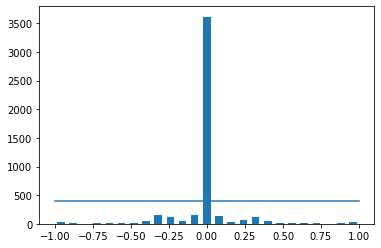

In [8]:
# PLOTTING A HISTOGRAM OF STEERING ANGLES #

num_bins = 25
samples_per_bin = 400  # LIMITING NUMBER OF SAMPLES FOR EACH STEERING ANGLE #
hist , bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:])* 0.5
plt.bar(center, hist, width=0.05)
print(data['steering'])
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 4753
removed: 3215
remaining: 1538


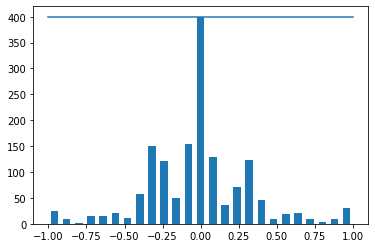

In [9]:
# REMOVING THE EXTRA DATA FOR ZERO STEERING ANGLE SO THAT THE MODEL DOESNT BECOME BIASED#

print('Total data:' , len(data))
remove_list = []

for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i]>= bins[j] and data['steering'][i]<= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)


print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))


hist, _ =  np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [10]:
# LOADING THE DATA AS WOULD BE REQUIRED FOR THE TRAINING MODEL #

print(data.iloc[1]) # To show what iloc does #

def load_img_steering(datadir, data):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths , steerings


image_paths, steerings = load_img_steering(datadir + '/IMG', data)


centre      center_2020_03_23_23_57_08_959.jpg
left        left_2020_03_23_23_57_08_959.jpg  
right       right_2020_03_23_23_57_08_959.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.83751e-05                       
Name: 30, dtype: object


Training samples: 1230 
 Valid Samples: 308


Text(0.5, 1.0, 'Valid_set')

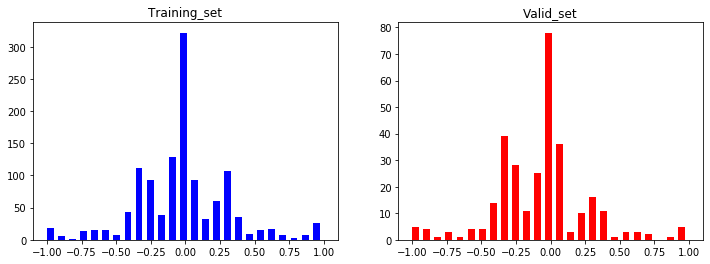

In [11]:
# VALIDATION SPLIT AND PLOTTING BOTH THE TRAINING DATA AND VAIDATION DATA HISTOGRAM #

X_train, X_valid, y_train , y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state=1)
print('Training samples: {} \n Valid Samples: {}'.format(len(X_train), len(X_valid)))

# PLOTTING THE HISTOGRAM #

fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train, bins = num_bins, width=0.05, color='blue')
axes[0].set_title('Training_set')
axes[1].hist(y_valid, bins = num_bins, width=0.05, color='red')
axes[1].set_title('Valid_set')


In [12]:

# AUGMENTATION TECHNIQUE ZOOMING
def zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    image= zoom.augment_image(image)
    return image

Text(0.5, 1, 'Zoomed image')

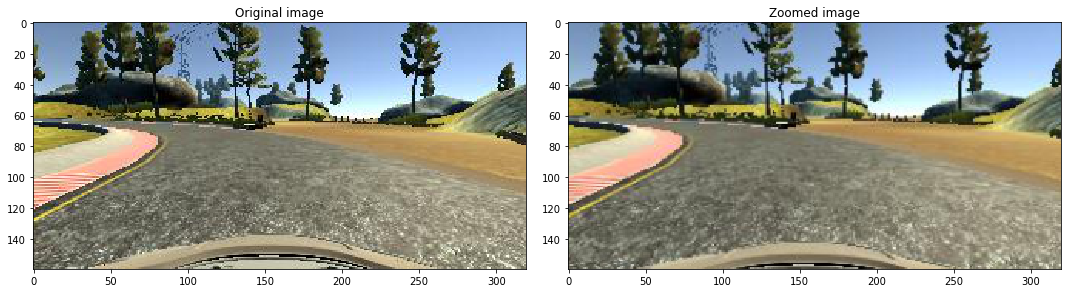

In [13]:
image = image_paths[random.randint(0,1000)]
original_image = npimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs= plt.subplots(1,2 , figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')



In [14]:
# AUGMENTATION TECHNIQUE FOR HORIZONTAL AND VERTICAL SHIFTS
def pan(image):
    pan = iaa.Affine(translate_percent= {"x": (-0.1,0.1), "y":(-0.1,0.1)}) # 10 percent right and left and 10 percent up and down
    image = pan.augment_image(image)
    return image

Text(0.5, 1, 'Panned image')

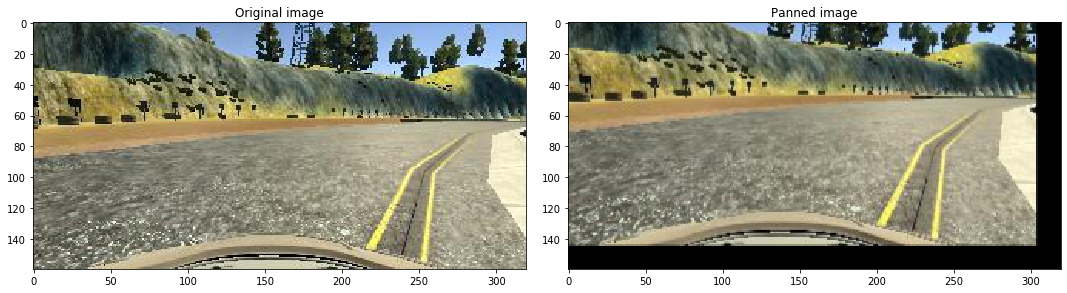

In [15]:
image = image_paths[random.randint(0,1000)]
original_image = npimg.imread(image)
panned_image = pan(original_image)

fig, axs= plt.subplots(1,2 , figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned image')


In [16]:
# AUGMENTATION TECHNIQUE FOR CHANGING BRIGHTNESS

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2,1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'Bright image')

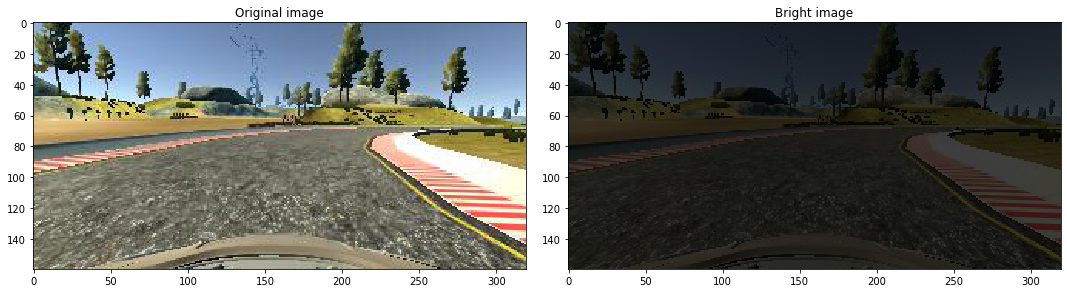

In [17]:
image = image_paths[random.randint(0,1000)]
original_image = npimg.imread(image)
bright_image = img_random_brightness(original_image)

fig, axs= plt.subplots(1,2 , figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(bright_image)
axs[1].set_title('Bright image')


In [18]:
#AUGMENTATION TECHNIQUE 4 FLIPPING FOR ADDITIONAL BALANCING OF DATASET

def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1) # SECOND ARGUMENT : 0= vertical flip, 1= horizontal flip, -1=combined 
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1, 'Flipped image -Steering angle:0.35929079999999997')

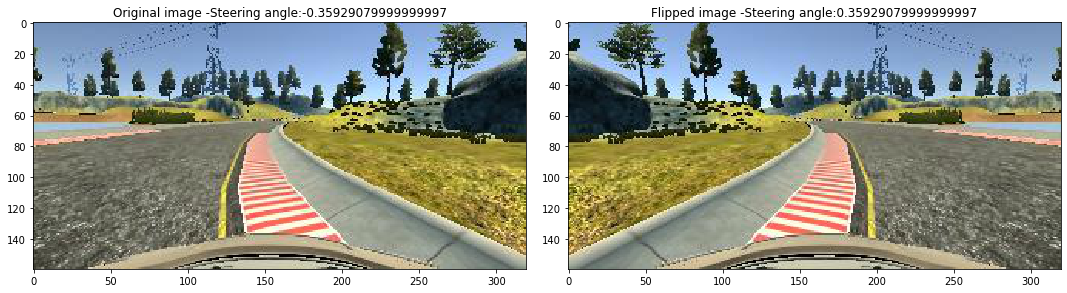

In [19]:
random_index=random.randint(0,1000)
image = image_paths[random_index]
steering_angle= steerings[random_index]

original_image = npimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs= plt.subplots(1,2 , figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image -' + 'Steering angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped image -' + 'Steering angle:' + str(flipped_steering_angle))

In [20]:
# APPLYING RANDOM AUGMENTATION ON THE IMAGES

def random_augment(image, steering_angle):
    image = npimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image , steering_angle = img_random_flip(image, steering_angle)
   
    return image, steering_angle

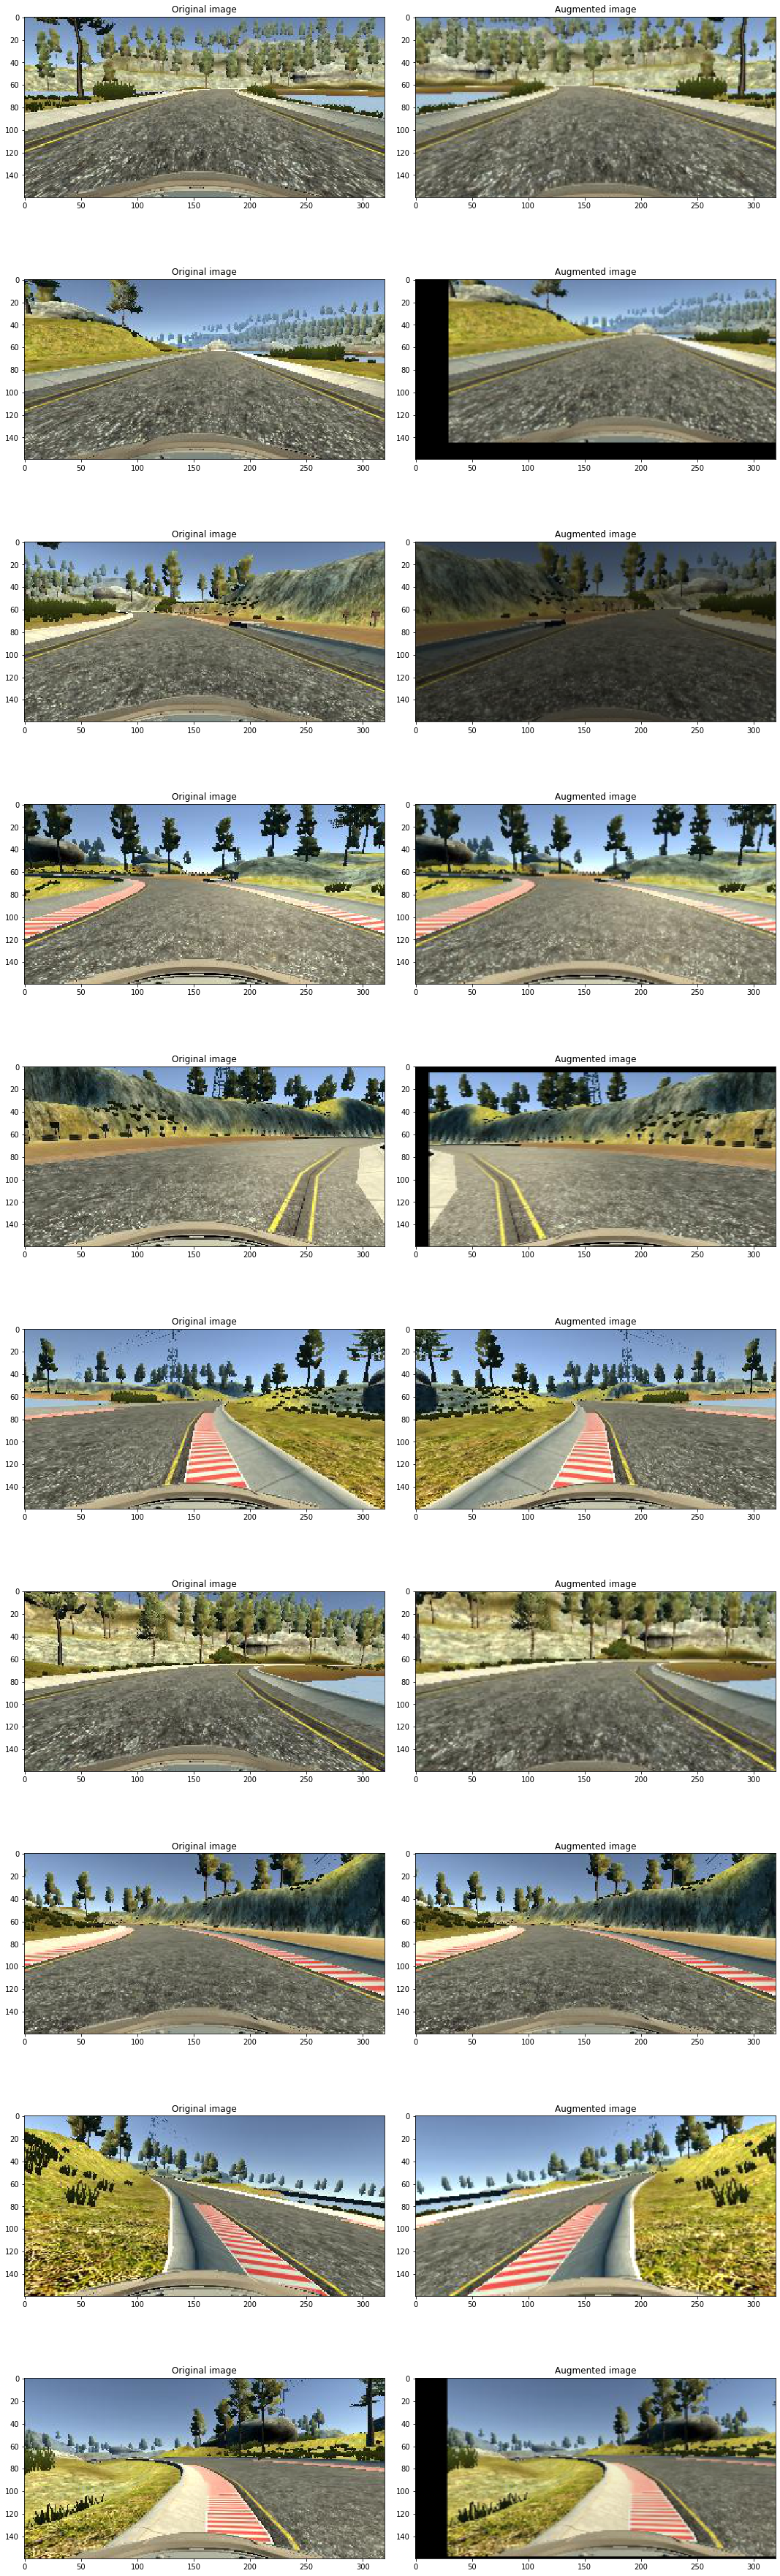

In [21]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0,len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = npimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original image')

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented image')

In [22]:
# PREPROCCESING IMAGES #

def img_preprocess(img):
    img = img[60:135,:,:] #Taking only the required part of the image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # YUV format is best for nvidia model
    img = cv2.GaussianBlur(img, (3,3) , 0) #Smoothening of the image
    img = cv2.resize(img, (200,66))
    img = img/255 #Normalizing
    return img


Text(0.5, 1.0, 'Preprocessed Image')

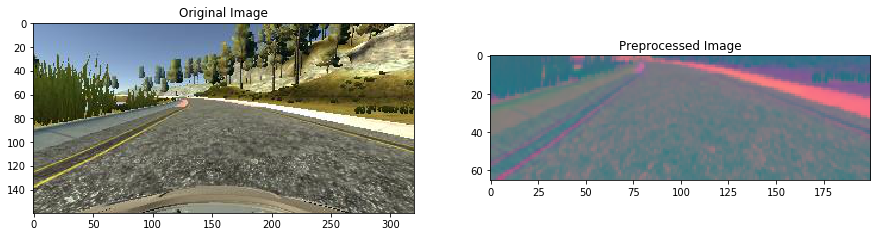

In [23]:
#DISPLAYING A RANDOM ORIGINAL AND ITS CORRESPONDING PREPROCESSED IMAGE

image = image_paths[100] #Random image
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig,axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [24]:
def batch_generator(image_path, steering_ang,batch_size, istraining ):
    while True:
        batch_img = []
        batch_steering = []

    for i in range(batch_size):
        random_index = random.randint(0, len(image_path) - 1)
      
        if istraining:
            im, steering = random_augment(image_path[random_index], steering_ang[random_index])
        else:
            im = npimg.imread(image_path[random_index])
            steering = steering_ang[random_index]

        im = img_preprocess(im)
        batch_img.append(im)
        batch_steering.append(steering)
    
    yield (np.asarray(batch_img), np.asarray(batch_steering))


In [25]:
# DEFINING THE NVIDIA MODEL

def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24 , (5, 5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
    model.add(Convolution2D(36, (5,5), strides=(2,2), activation='elu'))
    model.add(Convolution2D(48, (5,5),  strides =(2,2) , activation='elu'))
    model.add(Convolution2D(64, (3,3),  activation='elu'))

    model.add(Convolution2D(64, (3,3),  activation='elu'))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))

    model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model


In [26]:
# MODEL SUMMARY

model= nvidia_model()
print(model.summary())

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [ ]:
# FITTING THE MODEL TO OUR DATASET

model.fit(batch_generator(X_train,y_train, batch_size=16, istraining=True ), steps_per_epoch=300 , epochs=10, validation_data =batch_generator(X_valid,y_valid,16,0),validation_steps =200, verbose =0 , shuffle=1,callbacks=[TQDMNotebookCallback()])


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Loss')
plt.xlabel('epochs')


In [ ]:
model.save('model.h5')



In [ ]:
from google.colab import files
files.download('model.h5')